# Message passing neural network for segment classification on ACTS data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

In [1]:
# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

cuda = True

In [2]:
%load_ext autoreload
%autoreload 2

# System imports
from __future__ import print_function
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if cuda else "cpu")

# Local imports
from estimator import Estimator
from acts import process_hits_files, select_barrel_hits, select_hits
from graph import load_graphs, SparseGraph, feature_scale, graph_from_sparse
from model import SegmentClassifier
from estimator import Estimator


%matplotlib notebook

In [3]:
if cuda:
    np_to_torch = lambda x, volatile=False: (torch.tensor(x.astype(np.float32), requires_grad=False).cuda())
else:
    np_to_torch = lambda x, volatile=False: (torch.tensor(x.astype(np.float32), requires_grad=False))

torch_to_np = lambda x: x.cpu().numpy()

## Data utilities

## Prepare the data

In [4]:
input_dir = '/cms-sc17/graphNN/prod_mu10_pt1000_2017_07_29'

In [5]:
all_files = os.listdir(input_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))

n_files = 4
hits_files = [os.path.join(input_dir, hf) for hf in hits_files[:n_files]]

In [6]:
%%time

n_workers = 4
with mp.Pool(processes=n_workers) as pool:
    hits = process_hits_files(hits_files, pool)
    print('Applying selections')
    hits = pool.map(select_hits, hits)

# Concatenate everything together
hits = pd.concat(hits, ignore_index=True)

Loading /cms-sc17/graphNN/prod_mu10_pt1000_2017_07_29/clusters_11.csv
Loading /cms-sc17/graphNN/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Loading /cms-sc17/graphNN/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /cms-sc17/graphNN/prod_mu10_pt1000_2017_07_29/clusters_12.csv
Applying selections
CPU times: user 564 ms, sys: 312 ms, total: 876 ms
Wall time: 3min 9s


### Construct the dataset

In [7]:
# Select the particle keys
particle_keys = hits[['evtid', 'barcode']].drop_duplicates().values
np.random.shuffle(particle_keys)
particle_keys.shape

(54384, 2)

In [8]:
# Data config
n_tracks = 15
n_samples = particle_keys.shape[0] // n_tracks
feature_names = ['r', 'phi', 'z']
n_features = len(feature_names)
feature_scale = np.array([1000., np.pi, 1000.])
print('Preparing', n_samples, 'samples with', n_tracks, 'tracks each')
assert n_samples <= (particle_keys.shape[0] // n_tracks), 'Not enough tracks!'

Preparing 3625 samples with 15 tracks each


In [9]:
# Fixed number of hits and edges per sample in this dataset
n_det_layers = hits.layer.unique().shape[0]
n_hits = n_tracks * n_det_layers
n_edges = n_tracks**2 * (n_det_layers - 1)
edge_idx = np.arange(n_edges)
n_hits, n_edges

(150, 2025)

In [10]:
# Pre-allocate the dataset storage
full_X = np.zeros((n_samples, n_hits, n_features))
full_Ri = np.zeros((n_samples, n_hits, n_edges), dtype=np.uint8)
full_Ro = np.zeros((n_samples, n_hits, n_edges), dtype=np.uint8)
full_y = np.zeros((n_samples, n_edges), dtype=np.uint8)

In [11]:
%%time

sig_groups = hits.groupby(['evtid', 'barcode'])

# Loop over samples
for i in range(n_samples):
    # Pick out the particles for this sample
    sample_keys = particle_keys[i*n_tracks:(i+1)*n_tracks]
    sample_hits = pd.concat([sig_groups.get_group(tuple(k)) for k in sample_keys])

    # Select adjacent-layer hit pairs.
    sample_layers = sample_hits.layer.values
    adj_idx = np.stack(np.where((sample_layers[None,:] - sample_layers[:,None]) == 1), axis=1)
    
    # Fill the adjacency matrices
    full_Ri[i, adj_idx[:,1], edge_idx] = 1
    full_Ro[i, adj_idx[:,0], edge_idx] = 1
    
    # Fill the node features
    full_X[i] = sample_hits[feature_names].values / feature_scale
    
    # Fill the edge labels
    barcodes = sample_hits.barcode.values
    bc_in = np.matmul(barcodes[None], full_Ri[i]).squeeze(0)
    bc_out = np.matmul(barcodes[None], full_Ro[i]).squeeze(0)
    full_y[i] = (bc_in == bc_out)

CPU times: user 34 s, sys: 1.11 s, total: 35.1 s
Wall time: 35.1 s


### Visualize one sample

Need to put this code into a function, and write it so it will be easy to use
at model evaluation time (e.g., using model representation of the data).

In [12]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    """
    TODO: make segment coloring configurable.
    """
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    #ax0.set_xlim(-1100, 1100)
    ax1.set_xlim(-np.pi, np.pi)
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

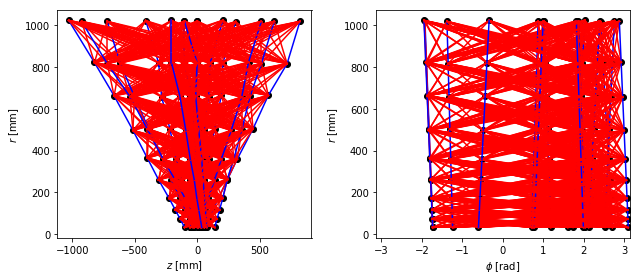

In [13]:
# Choose a sample to draw
i = 0
X = full_X[i] * feature_scale
Ri, Ro = full_Ri[i], full_Ro[i]
y = full_y[i]

draw_sample(X, Ri, Ro, y)

## Train the model

In [14]:
# Develop a batch generator here
def batch_generator(X, Ri, Ro, y, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            batch_X = np_to_torch(X[j:j+batch_size], volatile=volatile)
            batch_Ri = np_to_torch(Ri[j:j+batch_size], volatile=volatile)
            batch_Ro = np_to_torch(Ro[j:j+batch_size], volatile=volatile)
            batch_y = np_to_torch(y[j:j+batch_size], volatile=volatile)
            batch_inputs = [batch_X, batch_Ri, batch_Ro]
            yield batch_inputs, batch_y

In [15]:
# Model config
hidden_dim = 32
n_iters = 4

# Training config
batch_size = 32
n_epochs = 10
valid_frac = 0.2
test_frac = 0.2

In [16]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test // batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(2208, 704, 704, 3616)

In [17]:
# Partition the dataset
(train_X, test_X, train_Ri, test_Ri, train_Ro, test_Ro, train_y, test_y) = (
    train_test_split(full_X, full_Ri, full_Ro, full_y, test_size=n_test))
(train_X, valid_X, train_Ri, valid_Ri, train_Ro, valid_Ro, train_y, valid_y) = (
    train_test_split(train_X, train_Ri, train_Ro, train_y, test_size=n_valid))

In [18]:
print('Train shapes:', train_X.shape, train_Ri.shape, train_Ro.shape, train_y.shape)
print('Valid shapes:', valid_X.shape, valid_Ri.shape, valid_Ro.shape, valid_y.shape)
print('Test shapes: ', test_X.shape, test_Ri.shape, test_Ro.shape, test_y.shape)

Train shapes: (2217, 150, 3) (2217, 150, 2025) (2217, 150, 2025) (2217, 2025)
Valid shapes: (704, 150, 3) (704, 150, 2025) (704, 150, 2025) (704, 2025)
Test shapes:  (704, 150, 3) (704, 150, 2025) (704, 150, 2025) (704, 2025)


In [19]:
# Prepare the batch generators
train_batcher = batch_generator(train_X, train_Ri, train_Ro, train_y,
                                n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_X, valid_Ri, valid_Ro, valid_y, train=False,
                                n_samples=n_valid, batch_size=batch_size)

In [20]:
# Construct the model
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda)

2018-07-12 17:28:14.438749 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=70, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=105, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
  )
)
2018-07-12 17:28:14.439427 Parameters: 6881


In [21]:
#estim.load_checkpoint('Prune/000001.pt')

In [22]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches, 
              filename='Prune/000001.pt')

2018-07-12 17:28:14.469694 Epoch 0
2018-07-12 17:28:28.485555   training loss 0.308 time 14.0155s
2018-07-12 17:28:31.510789   validate loss 0.247
2018-07-12 17:28:31.510935  save checkpoint
2018-07-12 17:28:31.593249 Epoch 1
2018-07-12 17:28:45.370479   training loss 0.246 time 13.7771s
2018-07-12 17:28:48.365357   validate loss 0.247
2018-07-12 17:28:48.365507  save checkpoint
2018-07-12 17:28:48.369108 Epoch 2
2018-07-12 17:29:02.302012   training loss 0.246 time 13.9328s
2018-07-12 17:29:05.381236   validate loss 0.246
2018-07-12 17:29:05.381385  save checkpoint
2018-07-12 17:29:05.385053 Epoch 3
2018-07-12 17:29:19.235995   training loss 0.246 time 13.8504s
2018-07-12 17:29:22.302261   validate loss 0.246
2018-07-12 17:29:22.302416  save checkpoint
2018-07-12 17:29:22.306037 Epoch 4
2018-07-12 17:29:36.153252   training loss 0.245 time 13.8467s
2018-07-12 17:29:39.189296   validate loss 0.245
2018-07-12 17:29:39.190064  save checkpoint
2018-07-12 17:29:39.192733 Epoch 5
2018-07-12

In [23]:
#estim.load_checkpoint('Prune/0.pt')

### Loss curves

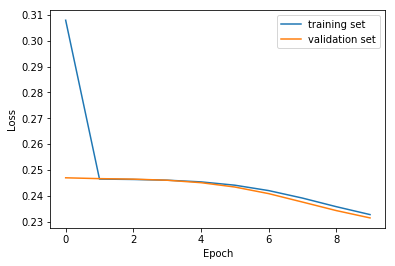

In [24]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

## Evaluate model on the test set

In [25]:
if cuda:
    torch.cuda.empty_cache()

In [26]:
# prepare test generator
with torch.no_grad():
    test_batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                                   n_samples=n_test, batch_size=batch_size)
    test_pred = torch_to_np(estim.predict(test_batcher, n_test_batches))

In [27]:
flat_y = test_y.flatten()
flat_pred = test_pred.flatten()
thresh = 0.5

print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

Test set results with threshold of 0.5
Accuracy:  0.9328


/home/ec2-user/miniconda3/envs/pytorch-training/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.0000
Recall:    0.0000


In [28]:
# Compute the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)

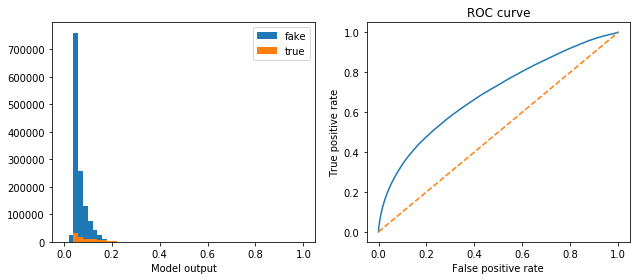

In [29]:
plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
#plt.xlim(.1,.125)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

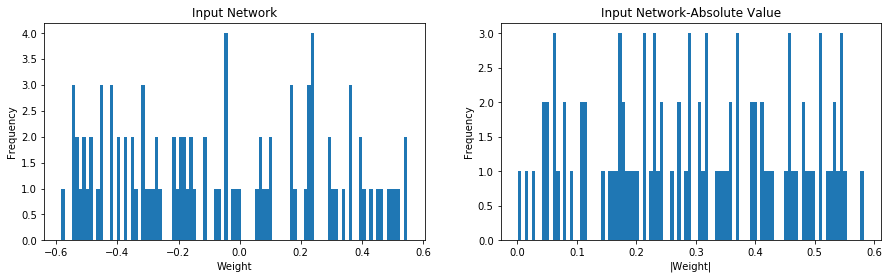

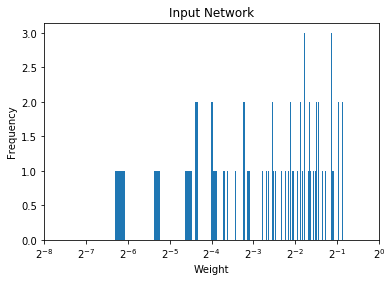

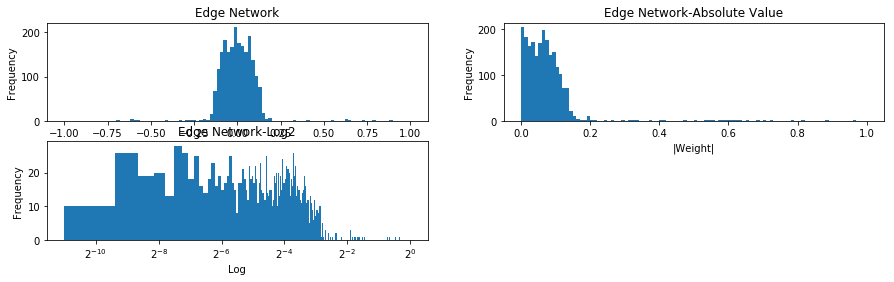

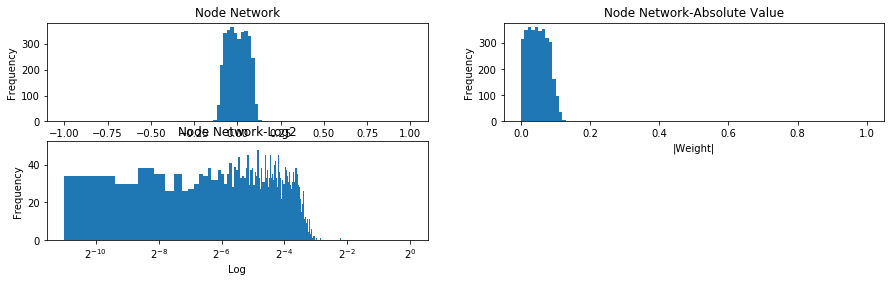

In [30]:
%matplotlib inline

with torch.no_grad():
    arr = torch_to_np(model.input_network[0].weight)
    arr = arr.flatten()
    
    
    plt.figure(figsize=(15,4))

    plt.subplot(1,2,1)
    plt.hist(arr, bins=100)
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.title('Input Network')

    plt.subplot(1,2,2)
    
    arr = [abs(x) for x in arr]
    plt.hist(arr, bins=100)
    plt.xlabel('|Weight|')
    plt.ylabel('Frequency')
    plt.title('Input Network-Absolute Value')

    plt.show()

    plt.hist(arr, bins=250)
    plt.xscale('log',basex=2)
    plt.xlim([2**-8,1])
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.title('Input Network')

    ###################################################

    plt.figure(figsize=(15,4))

    plt.subplot(2,2,1)

    arr_e = torch_to_np(model.edge_network.network[0].weight)
    arr_e = arr_e.flatten()

    plt.hist(arr_e, bins=100, range=(-1,1))
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.title('Edge Network')

    plt.subplot(2,2,2)
    arr_e2 = [abs(x) for x in arr_e]
    plt.hist(arr_e2, bins=100, range=(0,1))
    plt.xlabel('|Weight|')
    plt.ylabel('Frequency')
    plt.title('Edge Network-Absolute Value')

    plt.subplot(2,2,3)
    arr_e3 = arr_e2
    #arr_e3 = [math.log(x)/math.log(2) for x in arr_e2]
    plt.hist(arr_e3, bins=1000, range=(2**-11, 2**-0))
    plt.xscale('log',basex=2)
    #plt.xlim([2**-13,2**-4])
    plt.xlabel('Log')
    plt.ylabel('Frequency')
    plt.title('Edge Network-Log2')

    plt.show()

    ####################################################

    plt.figure(figsize=(15,4))

    plt.subplot(2,2,1)
    arr_n = torch_to_np(model.node_network.network[0].weight)
    arr_n = arr_n.flatten()
    plt.hist(arr_n, bins=100, range=(-1,1))
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.title('Node Network')

    plt.subplot(2,2,2)
    arr_n = [abs(x) for x in arr_n]
    plt.hist(arr_n, bins=100, range=(0,1))
    plt.xlabel('|Weight|')
    plt.ylabel('Frequency')
    plt.title('Node Network-Absolute Value')

    plt.subplot(2,2,3)
    #arr_e3 = [math.log(x)/math.log(2) for x in arr_e2]
    plt.hist(arr_n, bins=1000, range=(2**-11, 2**-0))
    plt.xscale('log',basex=2)
    #plt.xlim([2**-19,2**-4])
    plt.xlabel('Log')
    plt.ylabel('Frequency')
    plt.title('Node Network-Log2')

    plt.show()

## Visualize some samples

/home/ec2-user/miniconda3/envs/pytorch-training/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.933, precision 0.000, recall 0.000
accuracy 0.933, precision 0.000, recall 0.000
accuracy 0.933, precision 0.000, recall 0.000
accuracy 0.933, precision 0.000, recall 0.000


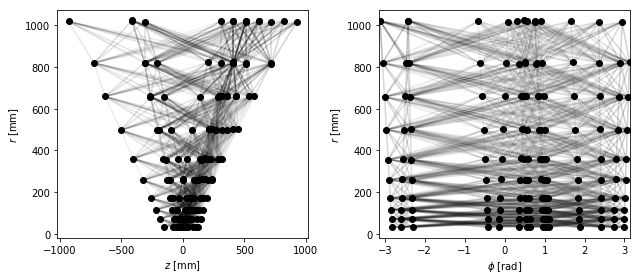

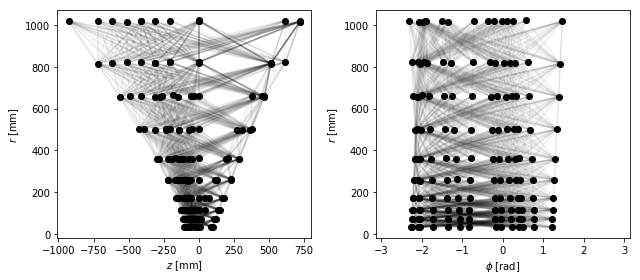

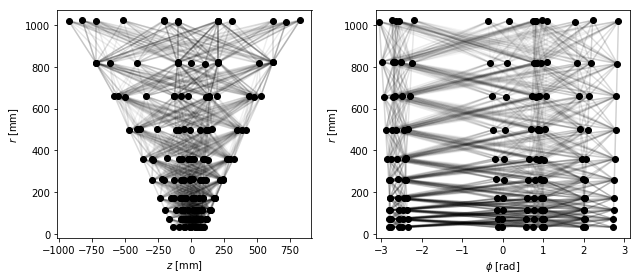

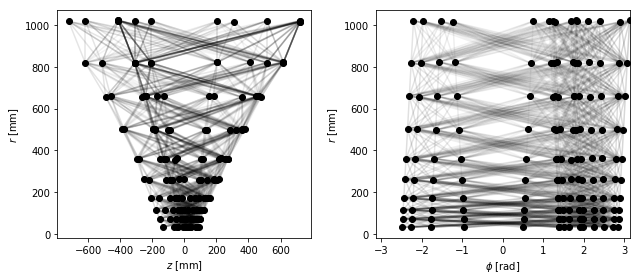

In [31]:
# Draw some samples
for i in range(4):
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.precision_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.recall_score(test_y[i], test_pred[i]>thresh)))
    draw_sample(test_X[i]*feature_scale, test_Ri[i], test_Ro[i], test_pred[i], alpha_labels=True);

## Visualize evolution of graph iterations

Let's take a sample and pull out the intermediate edge scores during graph iterations.
I'd like to visualize how the model converges on its chosen edges.

In [32]:
def graph_iter(model, X, H, Ri, Ro):
    # Shortcut connections
    H = torch.cat([H, X], dim=-1)
    # Edge network
    e = model.edge_network(H, Ri, Ro)
    # Node network
    H = model.node_network(H, e, Ri, Ro)
    return e, H

In [33]:
batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                          n_samples=1, batch_size=1)

In [34]:
model = estim.model

In [35]:
# Pull the inputs from the batcher
(X, Ri, Ro), y = next(batcher)

In [ ]:
# Apply input network
with torch.no_grad():
    H = model.input_network(X)

    for i in range(model.n_iters + 1):
        # Apply an iteration of the graph
        e, H = graph_iter(model, X, H, Ri, Ro)

        # Draw the edges
        draw_sample(torch_to_np(X)[0]*feature_scale,
                    torch_to_np(Ri)[0], torch_to_np(Ro)[0],
                    torch_to_np(e)[0], alpha_labels=True)

## Discussion

On 10 tracks and 10 barrel layers, the performance is great!